# Environment Setup

In [2]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import sqrt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from collections import Counter
from itertools import combinations
import random
import matplotlib.pyplot as plt


# For tokenization, we reuse Keras' Tokenizer for simplicity.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Load Data

In [4]:
train_df = pd.read_csv("./data/review.csv")
val_df = pd.read_csv("./data/validation.csv")
test_df = pd.read_csv("./data/prediction.csv")

with open("./data/product.json", "r") as f:
    product_data = json.load(f)
product_df = pd.DataFrame(product_data)

# Data Preprocessing

## Merge Product Metadata

In [5]:
def extract_main_category(cat_list):
    if not cat_list:
        return "Unknown"
    # Use the last category that is not an HTML artifact.
    last_cat = cat_list[-1]
    if isinstance(last_cat, str) and ('<' in last_cat or '>' in last_cat):
        if len(cat_list) >= 2:
            last_cat = cat_list[-2]
    return last_cat if last_cat else "Unknown"

In [6]:
product_df["MainCategory"] = product_df["category"].apply(extract_main_category)
product_df["BrandClean"] = product_df["brand"].fillna("Unknown")

train_df = train_df.merge(product_df[["ProductID", "MainCategory", "BrandClean"]], on="ProductID", how="left")
val_df = val_df.merge(product_df[["ProductID", "MainCategory", "BrandClean"]], on="ProductID", how="left")
test_df = test_df.merge(product_df[["ProductID", "MainCategory", "BrandClean"]], on="ProductID", how="left")

for df in [train_df, val_df, test_df]:
    df["MainCategory"].fillna("Unknown", inplace=True)
    df["BrandClean"].fillna("Unknown", inplace=True)

C:\Users\keliv\AppData\Local\Temp\ipykernel_22052\4172034746.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["MainCategory"].fillna("Unknown", inplace=True)
C:\Users\keliv\AppData\Local\Temp\ipykernel_22052\4172034746.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

## Encode IDs and Categorical Features

In [13]:
# User and Product IDs
unique_users = train_df["ReviewerID"].unique().tolist()
unique_items = train_df["ProductID"].unique().tolist()
user_to_index = {u: i+1 for i, u in enumerate(unique_users)}  # reserve 0 for unknown
item_to_index = {p: i+1 for i, p in enumerate(unique_items)}
unknown_user_idx = 0
unknown_item_idx = 0

train_user_idx = train_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
train_item_idx = train_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values
val_user_idx = val_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
val_item_idx = val_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values
test_user_idx = test_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
test_item_idx = test_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values

In [14]:
# Categories and Brands
unique_cats = pd.unique(train_df["MainCategory"]).tolist()
unique_brands = pd.unique(train_df["BrandClean"]).tolist()
cat_to_index = {c: i+1 for i, c in enumerate(unique_cats)}  # 0 for unknown
brand_to_index = {b: i+1 for i, b in enumerate(unique_brands)}
unknown_cat_idx = 0
unknown_brand_idx = 0

train_cat_idx = train_df["MainCategory"].apply(lambda x: cat_to_index.get(x, unknown_cat_idx)).values
train_brand_idx = train_df["BrandClean"].apply(lambda x: brand_to_index.get(x, unknown_brand_idx)).values
val_cat_idx = val_df["MainCategory"].apply(lambda x: cat_to_index.get(x, unknown_cat_idx)).values
val_brand_idx = val_df["BrandClean"].apply(lambda x: brand_to_index.get(x, unknown_brand_idx)).values
test_cat_idx = test_df["MainCategory"].apply(lambda x: cat_to_index.get(x, unknown_cat_idx)).values
test_brand_idx = test_df["BrandClean"].apply(lambda x: brand_to_index.get(x, unknown_brand_idx)).values

## Text Tokenization

In [15]:
# Use the "Text" column from training data. (If you wish, you can also combine "Summary".)
train_texts = train_df["Text"].fillna("").astype(str).tolist()
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
MAX_SEQ_LEN = 100
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# For validation and test, assume no review text is provided (or use empty strings)
val_padded = np.zeros((len(val_df), MAX_SEQ_LEN), dtype=int)
test_padded = np.zeros((len(test_df), MAX_SEQ_LEN), dtype=int)

## Prepare Target Ratings

In [16]:
train_ratings = train_df["Star"].values.astype(np.float32)
val_ratings = val_df["Star"].values.astype(np.float32)

# Create a PyTorch Dataset

In [17]:
class RatingDataset(Dataset):
    def __init__(self, user_ids, item_ids, text_seqs, cat_ids, brand_ids, ratings):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.item_ids = torch.tensor(item_ids, dtype=torch.long)
        # self.text_seqs = torch.tensor(text_seqs, dtype=torch.long)
        self.cat_ids = torch.tensor(cat_ids, dtype=torch.long)
        self.brand_ids = torch.tensor(brand_ids, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)
        
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        return (self.user_ids[idx],
                self.item_ids[idx],
                # self.text_seqs[idx],
                self.cat_ids[idx],
                self.brand_ids[idx],
                self.ratings[idx])
                
train_dataset = RatingDataset(train_user_idx, train_item_idx, train_padded, train_cat_idx, train_brand_idx, train_ratings)
val_dataset = RatingDataset(val_user_idx, val_item_idx, val_padded, val_cat_idx, val_brand_idx, val_ratings)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define the Model in PyTorch

In [40]:
class RatingPredictor(nn.Module):
    def __init__(self, num_users, num_items, vocab_size, num_cats, num_brands, max_seq_len,
                 user_emb_dim=32, item_emb_dim=32, word_emb_dim=100, cat_emb_dim=16, brand_emb_dim=16, hidden_dim=128):
        super(RatingPredictor, self).__init__()
        # Embedding layers
        self.user_emb = nn.Embedding(num_users, user_emb_dim, padding_idx=0)
        self.item_emb = nn.Embedding(num_items, item_emb_dim, padding_idx=0)
        # self.word_emb = nn.Embedding(vocab_size, word_emb_dim)
        self.cat_emb = nn.Embedding(num_cats, cat_emb_dim, padding_idx=0)
        self.brand_emb = nn.Embedding(num_brands, brand_emb_dim, padding_idx=0)
                
        # # Combined feature dimension: user + item + text features (3*50 = 150) + category + brand
        # combined_dim = user_emb_dim + item_emb_dim + 150 + cat_emb_dim + brand_emb_dim
        combined_dim = user_emb_dim + item_emb_dim + cat_emb_dim + brand_emb_dim
        self.fc1 = nn.Linear(combined_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.bn3 = nn.BatchNorm1d(hidden_dim//4)
        self.dropout3 = nn.Dropout(0.3)
        # Final output layer with scaled sigmoid so predictions fall in [1,5]
        self.fc_out = nn.Linear(hidden_dim//4, 1)
        
    def forward(self, user_ids, item_ids, text_seq, cat_ids, brand_ids):
        # Get embeddings for user and item
        user_vec = self.user_emb(user_ids)       # (batch, 32)
        item_vec = self.item_emb(item_ids)         # (batch, 32)
        
        # Process review text
        # text_seq: (batch, max_seq_len) -> word embeddings: (batch, max_seq_len, word_emb_dim)
        # text_emb = self.word_emb(text_seq)         # (batch, max_seq_len, word_emb_dim)
        # text_emb = text_emb.transpose(1, 2)         # (batch, word_emb_dim, max_seq_len)
        
        # Apply three parallel convolutions with different kernel sizes
        # conv3 = F.relu(self.conv1d_3(text_emb))     # (batch, 50, L3)
        # pool3 = self.pool(conv3).squeeze(-1)         # (batch, 50)
        
        # conv4 = F.relu(self.conv1d_4(text_emb))     # (batch, 50, L4)
        # pool4 = self.pool(conv4).squeeze(-1)         # (batch, 50)
        
        # conv5 = F.relu(self.conv1d_5(text_emb))     # (batch, 50, L5)
        # pool5 = self.pool(conv5).squeeze(-1)         # (batch, 50)
        
        # Concatenate text features from all kernels
        # text_features = torch.cat([pool3, pool4, pool5], dim=1)  # (batch, 150)
        
        # Get metadata embeddings
        cat_vec = self.cat_emb(cat_ids)             # (batch, cat_emb_dim)
        brand_vec = self.brand_emb(brand_ids)         # (batch, brand_emb_dim)
        
        # Concatenate all features
        # combined = torch.cat([user_vec, item_vec, text_features, cat_vec, brand_vec], dim=1)
        combined = torch.cat([user_vec, item_vec, cat_vec, brand_vec], dim=1)
        
        # Fully connected layers with BatchNorm and Dropout
        x = F.relu(self.bn1(self.fc1(combined)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        # Use a scaled sigmoid so that outputs are between 1 and 5.
        out = 1 + 4 * torch.sigmoid(self.fc_out(x))
        return out.squeeze(1)

In [41]:
# Define sizes (add +1 to account for unknown index 0)
num_users = len(user_to_index) + 1
num_items = len(item_to_index) + 1
vocab_size = min(10000, len(tokenizer.word_index) + 1)
num_cats = len(cat_to_index) + 1
num_brands = len(brand_to_index) + 1

model = RatingPredictor(num_users, num_items, vocab_size, num_cats, num_brands, MAX_SEQ_LEN)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RatingPredictor(
  (user_emb): Embedding(2753, 32, padding_idx=0)
  (item_emb): Embedding(6337, 32, padding_idx=0)
  (cat_emb): Embedding(38, 16, padding_idx=0)
  (brand_emb): Embedding(3618, 16, padding_idx=0)
  (fc1): Linear(in_features=96, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)

# Training

## Training Setup

In [42]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 15

In [37]:
def evaluate(model, loader):
    model.eval()
    losses = []
    preds = []
    trues = []
    with torch.no_grad():
        for batch in loader:
            # user_ids, item_ids, text_seqs, cat_ids, brand_ids, ratings = batch
            user_ids, item_ids, cat_ids, brand_ids, ratings = batch
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            # text_seqs = text_seqs.to(device)
            text_seqs = None
            cat_ids = cat_ids.to(device)
            brand_ids = brand_ids.to(device)
            ratings = ratings.to(device)
            outputs = model(user_ids, item_ids, text_seqs, cat_ids, brand_ids)
            loss = criterion(outputs, ratings)
            losses.append(loss.item() * ratings.size(0))
            preds.extend(outputs.cpu().numpy())
            trues.extend(ratings.cpu().numpy())
    avg_loss = np.sum(losses) / len(loader.dataset)
    rmse_val = sqrt(np.mean((np.array(preds) - np.array(trues)) ** 2))
    return avg_loss, rmse_val

## Training Loop

In [ ]:
train_losses = []
val_losses = []
val_rmses = []
best_val_loss = float('inf')
best_model_path = "checkpoint_2.pth"

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        # user_ids, item_ids, text_seqs, cat_ids, brand_ids, ratings = batch
        user_ids, item_ids, cat_ids, brand_ids, ratings = batch
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        # text_seqs = text_seqs.to(device)
        text_seqs = None
        cat_ids = cat_ids.to(device)
        brand_ids = brand_ids.to(device)
        ratings = ratings.to(device)
        
        optimizer.zero_grad()
        outputs = model(user_ids, item_ids, text_seqs, cat_ids, brand_ids)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * ratings.size(0)
        
    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_rmse = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -- Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}  Val RMSE: {val_rmse:.4f}")

    # Save checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'rmse': val_rmse,
        }, best_model_path)
        print(f'Checkpoint saved at epoch {epoch+1} with validation loss {val_loss:.4f}')

## Visualization

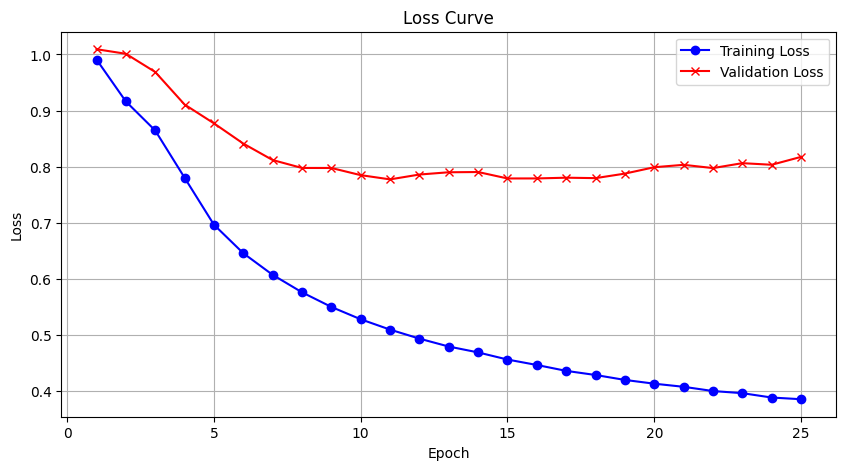

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', linestyle='-', color='r', label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Generate Predictions

In [43]:
def generate_predictions(model, user_ids, item_ids, text_seqs, cat_ids, brand_ids):
    model.eval()
    inputs = {
        "user_ids": torch.tensor(user_ids, dtype=torch.long).to(device),
        "item_ids": torch.tensor(item_ids, dtype=torch.long).to(device),
        # "text_seqs": torch.tensor(text_seqs, dtype=torch.long).to(device),
        "text_seqs": None,
        "cat_ids": torch.tensor(cat_ids, dtype=torch.long).to(device),
        "brand_ids": torch.tensor(brand_ids, dtype=torch.long).to(device)
    }
    with torch.no_grad():
        preds = model(inputs["user_ids"], inputs["item_ids"], inputs["text_seqs"],
                      inputs["cat_ids"], inputs["brand_ids"])
    return preds.cpu().numpy()

In [44]:
# load the best model
checkpoint = torch.load("checkpoint.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Validation set

In [45]:
# Predictions for validation set
val_preds = generate_predictions(model, val_user_idx, val_item_idx, val_padded, val_cat_idx, val_brand_idx)
# Compute RMSE manually (or use evaluate.py later)
val_rmse = sqrt(np.mean((val_preds - val_ratings) ** 2))
print(f"Final Validation RMSE: {val_rmse:.4f}")

Final Validation RMSE: 0.8818


In [50]:
# Save validation predictions to CSV (for evaluate.py)
val_pred_df = pd.DataFrame({
    "ReviewerID": val_df["ReviewerID"],
    "ProductID": val_df["ProductID"],
    "Star": val_preds
})
val_pred_df.to_csv("validation_prediction.csv", index=False)

## Test set

In [51]:
# Predictions for test set
test_preds = generate_predictions(model, test_user_idx, test_item_idx, test_padded, test_cat_idx, test_brand_idx)
test_pred_df = pd.DataFrame({
    "ReviewerID": test_df["ReviewerID"],
    "ProductID": test_df["ProductID"],
    "Star": test_preds
})
test_pred_df.to_csv("prediction_filled.csv", index=False)
print("Saved validation_prediction.csv and prediction_filled.csv")

Saved validation_prediction.csv and prediction_filled.csv
